Podaci nisu podijeljeni na train/valid/test

In [ ]:
import re
import spacy
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
nlp = spacy.load(
    "en_core_web_lg"
)
df = pd.read_csv("train_all_tasks.csv")

Svaki redak uzorka sadržava:

In [ ]:
print(df.columns)

Broj redaka:

In [ ]:
print(df.shape[0])

Radimo s nebalansiranim skupom podataka

Broj redaka iz klase seksistički:

In [ ]:
print(len(df[df['label_sexist'] == 'sexist']))

Broj redaka iz klase neseksistički:

In [ ]:
print(len(df[df['label_sexist'] == 'not sexist']))

Nema Nan podataka:

In [ ]:
print(df.isnull().values.any())

In [ ]:
najvise = 0
seksisti = []
neseksisti = []
prosrijeci = [0, 0]
djelitelj = [0, 0]
for i in df.itertuples():
    doc = nlp(i.text.lower())
    najvise = max(najvise, len(doc))
    br_rijeci = len(doc)
    tret = [token.lemma_
         for token in doc
         if not token.is_stop and not token.is_punct and token.is_alpha]
    if i.label_sexist == 'sexist':
        prosrijeci[0] += br_rijeci
        djelitelj[0] += 1
        for j in tret:
            seksisti.append(j)
    else:
        prosrijeci[1] += br_rijeci
        djelitelj[1] += 1
        for j in tret:
            neseksisti.append(j)

Najčešće riječi za klasu seksisti:

In [ ]:
word_freq = Counter(seksisti)
common_words = word_freq.most_common(5)
for i in common_words:
    print(i)

Najčešće riječi za klasu ne seksisti:

In [ ]:
word_freq = Counter(neseksisti)
common_words = word_freq.most_common(5)
for i in common_words:
    print(i)

Broj prosječnih riječi: (tokena)
[seksisti, neseksisti]

In [ ]:
print(najvise)
prosrijeci[0] /= djelitelj[0]
prosrijeci[1] /= djelitelj[1]
print(prosrijeci)

Razdvojimo na train/valid/test:

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

lista_tekst = df["text"]
lista_label = df["label_sexist"]

for train_index, test_index in sss.split(lista_tekst, lista_label):
    X_train, X_test = lista_tekst[train_index], lista_tekst[test_index]
    y_train, y_test = lista_label[train_index], lista_label[test_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_test = {"text": X_test, "label": y_test}
    df_test = pd.DataFrame(d_test)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)

lista_tekst = np.array(df_train["text"])
lista_label = np.array(df_train["label"])

for train_index, valid_index in sss.split(lista_tekst, lista_label):
    X_train, X_valid = lista_tekst[train_index], lista_tekst[valid_index]
    y_train, y_valid = lista_label[train_index], lista_label[valid_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_valid = {"text": X_valid, "label": y_valid}
    df_valid = pd.DataFrame(d_valid)

print(len(df_test), len(df_valid), len(df_train))


Pogledajmo [URL], [USER], emoji:

Za [URL]:

In [ ]:
#nije najtočnije ali radi skoro
urlovi = [0, 0]
sexist_c = len(df_train[df_train['label'] == 'sexist'])
nsexist_c = len(df_train[df_train['label'] == 'not sexist'])
for i in df_train.itertuples():
    doc = nlp(i.text)
    tret = [token
         for token in doc
         if "URL" == str(token)]
    kolko = len(tret)
    if i.label == 'sexist':
        urlovi[0] += kolko
    else:
        urlovi[1] += kolko
print(urlovi)
print(urlovi[0] / sexist_c, urlovi[0] / nsexist_c)

Za [USER]:

In [ ]:
#nije najtočnije ali radi skoro
useri = [0, 0]
for i in df_train.itertuples():
    doc = nlp(i.text)
    tret = [token
         for token in doc
         if "USER" == str(token)]
    kolko = len(tret)
    if i.label == 'sexist':
        useri[0] += kolko
    else:
        useri[1] += kolko
print(useri)
print(useri[0] / sexist_c, useri[1] / nsexist_c)

Za emoji:

In [ ]:
import re
a_list = ['🤔 🙈 me así, bla es se 😌 ds 💕👭👙']
re.findall(r'[^\w\s,]', a_list[0])

In [ ]:
emojiji = [0, 0]
for i in df_train.itertuples():
    doc = nlp(i.text)
    kolko = len(re.findall(r'[^\w\s,]', str(doc)[0]))
    if i.label == 'sexist':
        emojiji[0] += kolko
    else:
        emojiji[1] += kolko
print(emojiji)
print(emojiji[0] / sexist_c, emojiji[1] / nsexist_c)

SVM + WORD2VEC

In [1196]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

corpus_text = '\n'.join(df_train['text'])
sentences = corpus_text.split('\n')
sentences = [line.lower().split(' ') for line in sentences]

def clean(s):
    return [w.strip(',."!?:;()\'') for w in s]

sentences = [clean(s) for s in sentences if len(s) > 0]

w2v_model = Word2Vec(sentences,
                     vector_size=100,
                     window=5,
                     epochs=40)
vectors = w2v_model.wv


In [1197]:
w2v_model.wv.most_similar(positive=["man"])


[('woman', 0.48810163140296936),
 ('person', 0.458730012178421),
 ('guy', 0.45082592964172363),
 ('slut', 0.3938337564468384),
 ('strong', 0.38219088315963745),
 ('joke', 0.37239816784858704),
 ('shot', 0.3668678402900696),
 ('kid', 0.3453383445739746),
 ('solution', 0.3406006991863251),
 ('husband', 0.33900532126426697)]

In [1191]:
def W2Vvectorize(train):
    corpus_text = '\n'.join(train)
    sentences = corpus_text.split('\n')
    sentences = [line.lower().split(' ') for line in sentences]

    def clean(s):
        return [w.strip(',."!?:;()\'') for w in s]

    sentences = [clean(s) for s in sentences if len(s) > 0]
    vector=[]
    for sent in sentences:
        sent_vec=np.zeros(100)
        count =0
        for word in sent: 
            if word in w2v_model.wv:
                vec = vectors[word]
                sent_vec += vec 
                count += 1
        if count != 0:
            sent_vec /= count #normalize
        vector.append(sent_vec)
    return vector

In [1198]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
clf = SVC()

lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)

nova_lista = W2Vvectorize(df_train["text"])

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf = clf.fit(nova_lista, lista_label)


In [1199]:
print("Training:"+str(clf.score(nova_lista, lista_label)))

lista_label_test = np.array(df_test["label"])
lista_label_test = le.fit_transform(lista_label_test)
nova_lista_test = W2Vvectorize(df_test["text"])

print("Test:"+str(clf.score(nova_lista_test,lista_label_test)))


Training:0.8240816326530612
Test:0.7775


In [1194]:
def evaluate(model, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = W2Vvectorize(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

              precision    recall  f1-score   support

  not sexist       0.78      0.98      0.87      2120
      sexist       0.72      0.14      0.23       680

    accuracy                           0.78      2800
   macro avg       0.75      0.56      0.55      2800
weighted avg       0.77      0.78      0.71      2800

Precision:   0.78
   Recall:   0.78
       F1:   0.78


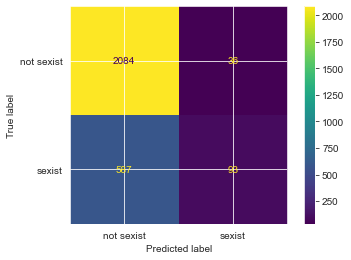

In [1200]:
evaluate(clf, df_test.text, lista_label_test)

In [1177]:
tekst = "bitch"
tekst_v = W2Vvectorize(tekst)
if round(np.mean(clf.predict(tekst_v))) == 1: print('sexist')
else: print('not sexist')

not sexist


SVM +TF_IDF

In [1113]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df_train["text"]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)


In [1114]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
clf = SVC()

lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)

clf = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto'))
clf = clf.fit(X, lista_label)


In [1115]:
print("Training:"+str(clf.score(X, lista_label)))

lista_label_test = np.array(df_test["label"])
lista_label_test = le.transform(lista_label_test)
nova_lista_test = vectorizer.transform(df_test["text"])

print("Test:"+str(clf.score(nova_lista_test,lista_label_test)))

Training:0.9171428571428571
Test:0.7610714285714286


In [1116]:
def evaluate(model, tf_idf, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = tf_idf.transform(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

              precision    recall  f1-score   support

  not sexist       0.76      1.00      0.86      2120
      sexist       0.92      0.02      0.03       680

    accuracy                           0.76      2800
   macro avg       0.84      0.51      0.45      2800
weighted avg       0.80      0.76      0.66      2800

Precision:   0.76
   Recall:   0.76
       F1:   0.76


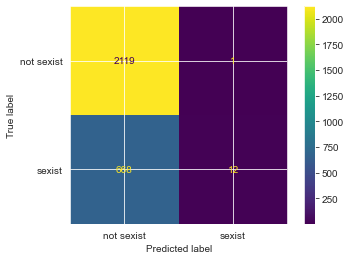

In [1117]:
evaluate(clf, vectorizer, df_test.text, lista_label_test)

In [1142]:
tekst = "you are bitch"
tekst_v = vectorizer.transform([tekst])
if round(np.mean(clf.predict(tekst_v))) == 1: print('sexist')
else: print('not sexist')

sexist
